<a href="https://colab.research.google.com/github/tirtthshah/text-to-image-pipeline/blob/main/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TASK-1 Complete

In [31]:
!pip install torch torchvision diffusers transformers accelerate safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 619.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 400.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 855.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 838.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 723.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [11]:
import os

hf_token = os.environ.get("HF_TOKEN")
from huggingface_hub import login
login(hf_token)

In [4]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "prompthero/openjourney"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Enter your thought(prompt): a black Horse at river side painting 


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  0%|          | 0/50 [00:00<?, ?it/s]

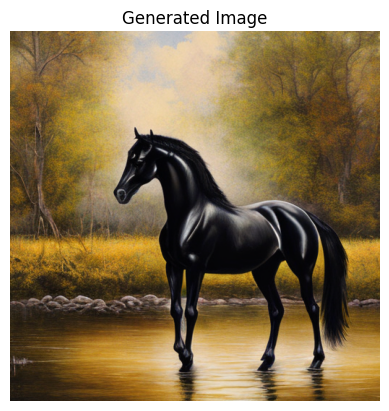

In [12]:
from diffusers import StableDiffusionPipeline
from transformers import AutoTokenizer, AutoModel
import torch
import re
import matplotlib.pyplot as plt

model_id = "prompthero/openjourney"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

prompt = input("Enter your thought(prompt): ")
clean_prompt = preprocess_text(prompt)



tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

inputs = tokenizer(clean_prompt, return_tensors="pt", truncation=True, padding=True)
with torch.no_grad():
    embeddings = model(**inputs).last_hidden_state.mean(dim=1)
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, embedding_dim=768, noise_dim=100, img_channels=3, feature_maps=64):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim + noise_dim, feature_maps * 8 * 4 * 4),
            nn.BatchNorm1d(feature_maps * 8 * 4 * 4),
            nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps, img_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, embedding, noise):
        x = torch.cat((embedding, noise), dim=1)
        x = self.fc(x).view(-1, 512, 4, 4)
        return self.deconv(x)

        # fake_image = generator(embeddings) # This line seems out of place


image = pipe(prompt).images[0]

import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis("off")
plt.title("Generated Image")
plt.show()